# Getting started

Optyx provides tensor network evaluation for hybrid circuits over photonic and qubit modes.

The package is structured into three modules giving different *generators* for the nodes in the network.
- ZX diagrams: generated by the phased `zx.Z` and `zx.X` spiders and the `zx.H` box.
- ZW diagrams: generated by the split map `zx.W` and its dagger, `zw.Z` spiders acting on bosonic modes, as well as bosonic states `zw.Create` and effects `zw.Select`.
- LO circuits: generated by gates `lo.Phase`, `lo.BS`, `lo.BBS`, `lo.TBS` and `lo.MZI`.

The `optyx.Diagram` class can store any (well-typed) composition of the above generators together with the `optyx.DualRail` box.

The `channel.Circuit` and `channel.Channel` classes provide the simulation of any composition as a completely positive maps. 
It gives further generators `Encode`, `Measure`, `Discard` and `CPhase`, allowing to construct arbitrary mixed circuits with measurements and classical control.

### Build a linear optical circuit

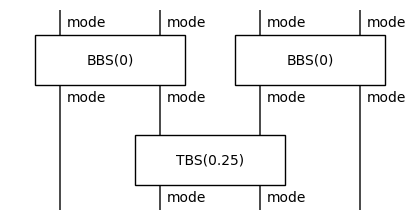

In [3]:
from optyx import lo

circuit = lo.BS @ lo.BS >> lo.Id(1) @ lo.TBS(0.25) @ lo.Id(1)
circuit.foliation().draw()

### Evaluate an amplitude of the circuit

In [135]:
from optyx import zw

state = zw.Create(1, 0, 0, 1)
effect = zw.Select(0, 1, 0, 1)

(state >> circuit >> effect).to_zw().to_tensor().eval()

Tensor[complex128]([0.+0.35355339j], dom=Dim(1), cod=Dim(1))

### Evaluate a marginal output distribution

In [136]:
from optyx.channel import Channel, Measure, Discard, qmode

channel = Channel('circuit', circuit) >> Discard(qmode ** 2) @ Measure(qmode) @ Discard(qmode)

distribution =  Channel('product state', state) >> channel
distribution.double().to_zw().to_tensor(max_dim=3).eval().array.round(3)

array([0.625+0.j, 0.25 +0.j, 0.125+0.j])

### Interface with Perceval

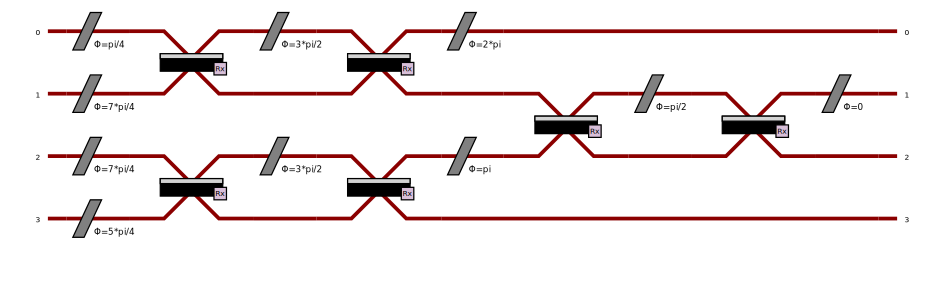

In [168]:
import perceval as pcvl

perceval_circuit = (state >> circuit).to_path()._umatrix_to_perceval_circuit()
perceval_distribution = (state >> circuit).to_path().prob_with_perceval().array

pcvl.pdisplay(perceval_circuit)

In [175]:
from optyx.utils import tensor_2_amplitudes

tn_diagram = (Channel('doubled state', state >> circuit) >> Measure(qmode ** 4)).double().to_zw().to_tensor()
tn_distribution = tensor_2_amplitudes(tn_diagram, 2)
assert np.allclose(tn_distribution, perceval_distribution)

### Build an entangled state in ZX

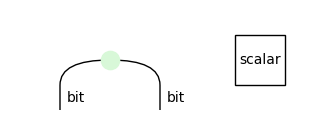

array([[0.70710678+0.j, 0.        +0.j],
       [0.        +0.j, 0.70710678+0.j]])

In [196]:
from optyx import zx, optyx
import numpy as np
from discopy.drawing import Equation

qubit_state = zx.Z(0, 2) @ zx.Scalar(1/np.sqrt(2))
qubit_state.foliation().draw()
qubit_state.to_tensor().eval().array

### Interface with PyZX

In [197]:
import pyzx

assert np.allclose(qubit_state.to_pyzx().to_tensor(), qubit_state.to_tensor().eval().array)
pyzx.draw(qubit_state.to_pyzx())

### Evaluate a hybrid channel with qubits and qmodes.

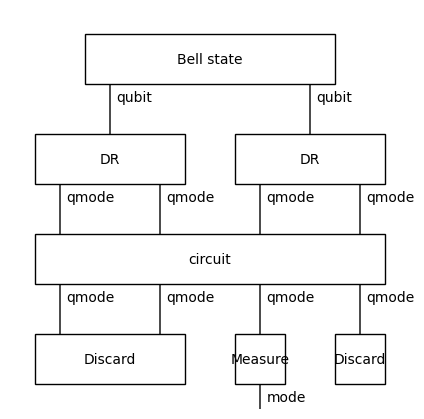

In [157]:
from optyx.channel import qubit

q_state = Channel('Bell state', qubit_state)
dual_rail = Channel('DR', optyx.DualRail())
hybrid_setup = q_state >> dual_rail @ dual_rail >> channel
hybrid_setup.foliation().draw()

In [158]:
hybrid_setup.double().to_zw().to_tensor(max_dim=3).eval().array.round(3)

array([0.75+0.j, 0.  +0.j, 0.25+0.j])

### Compute the distribution in the presence of photon loss

In [142]:
import numpy as np

eff = 0.97
kraus= zw.W(2) >> zw.Endo(np.sqrt(eff)) @ zw.Endo(np.sqrt(1-eff))
loss = Channel(name=f'loss({eff})', kraus=kraus, dom=qmode, cod=qmode, env=optyx.mode)
uniform_loss = loss.tensor(*[loss for _ in range(3)])
lossy_setup = q_state >> dual_rail @ dual_rail >> uniform_loss >> channel
lossy_setup.double().to_zw().to_tensor(max_dim=3).eval().array.round(7)

array([0.750225+0.j, 0.01455 +0.j, 0.235225+0.j])

### Compute the distribution in the presence of a qubit error

In [180]:
from optyx.channel import Circuit

dephasing = Channel(name='Zerror', kraus=optyx.Spider(1, 2, optyx.bit), dom=qubit, cod=qubit, env=optyx.bit)
dephased_setup = q_state >> dephasing @ Circuit.id(qubit) >> dual_rail @ dual_rail >> channel
dephased_setup.double().to_zw().to_tensor(max_dim=3).eval().array.round(7)

array([0.625+0.j, 0.25 +0.j, 0.125+0.j])